In [5]:
# Importamos las librerías necesarias

# Tratamiento de datos
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración para poder visualizar todas las columnas y filas de los DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Fase 2: Transformación de los datos.

In [4]:
# Leo archivo CSV
hr_data_limpio = pd.read_csv("hr_data_limpio.csv", index_col=0)

# Lo guardo en un DataFrame
df_limpia = pd.DataFrame(hr_data_limpio)

# Hago una copia del DataFrame que iré imputando
df_imputada = df_limpia.copy()

## B. Gestión de nulos

En el primer paso ya hicimos un primer filtro donde eliminamos algunas columnas con valores duplicados, insuficientes o incongruentes. Algunas de ellas tenían un alto porcentaje de nulos y no aportaban ninguna información relevante por lo que se decidió eliminarlas. En este paso entraremos más en detalle cómo gestionar los nulos de las columnas restantes.

In [199]:
# Seleccionar las columnas que tienen al menos un valor nulo
columnas_con_nulos = df_imputada.columns[df_imputada.isnull().any()]
print(f"Las columnas que tienen nulos son: \n{columnas_con_nulos}\n")
print(f"El porcentaje de nulos de cada columna son: \n{df_imputada[columnas_con_nulos].isnull().sum() / df_imputada.shape[0]}\n")
print(f"Y son de tipo: \n{df_imputada[columnas_con_nulos].dtypes}")

Las columnas que tienen nulos son: 
Index(['BusinessTravel', 'DailyRate', 'Department', 'EducationField',
       'EmployeeNumber', 'HourlyRate', 'MaritalStatus', 'MonthlyIncome',
       'OverTime', 'PerformanceRating', 'TotalWorkingYears',
       'WorkLifeBalance'],
      dtype='object')

El porcentaje de nulos de cada columna son: 
BusinessTravel       0.478315
DailyRate            0.076828
Department           0.812887
EducationField       0.461586
EmployeeNumber       0.267038
HourlyRate           0.052045
MaritalStatus        0.403346
MonthlyIncome        0.522305
OverTime             0.418835
PerformanceRating    0.120818
TotalWorkingYears    0.325898
WorkLifeBalance      0.066914
dtype: float64

Y son de tipo: 
BusinessTravel        object
DailyRate            float64
Department            object
EducationField        object
EmployeeNumber        object
HourlyRate           float64
MaritalStatus         object
MonthlyIncome        float64
OverTime              object
PerformanceR

### 1. Imputaciones numéricas

Las columnas numéricas (float) con nulos son: `DailyRate`, `HourlyRate`, `MonthlyIncome`, `PerformanceRating`, `TotalWorkingYears`, `WorkLifeBalance`.

In [200]:
# Obtenemos la lista de columnas numericas que tienen nulos
nulos_num = df_imputada[df_imputada.columns[df_imputada.isnull().any()]].select_dtypes(include = np.number).columns
print(f"Columnas numéricas con nulos:\n{nulos_num} ")

Columnas numéricas con nulos:
Index(['DailyRate', 'HourlyRate', 'MonthlyIncome', 'PerformanceRating',
       'TotalWorkingYears', 'WorkLifeBalance'],
      dtype='object') 


Comprobamos aquellos atributos que no superas el 15% de nulos.

In [201]:
# Calcula el porcentaje de valores nulos para cada atributo
porcentaje_nulos = df_imputada[nulos_num].isna().mean() * 100

# Filtra los atributos donde el porcentaje de nulos sea mayor al 80%
columnas_15_nulos = porcentaje_nulos[porcentaje_nulos <= 15]

# Obtiene los nombres de los atributos 
columnas_15 = columnas_15_nulos.index.tolist()
print(f"Atributos numéricos que no osuperan el 15/%/ de valores nulos: {columnas_15}")

Atributos numéricos que no osuperan el 15/%/ de valores nulos: ['DailyRate', 'HourlyRate', 'PerformanceRating', 'WorkLifeBalance']


Lo siguiente que haremos es ver si dentro de las columnas numéricas donde tenemos nulos tenemos valores atípicos.

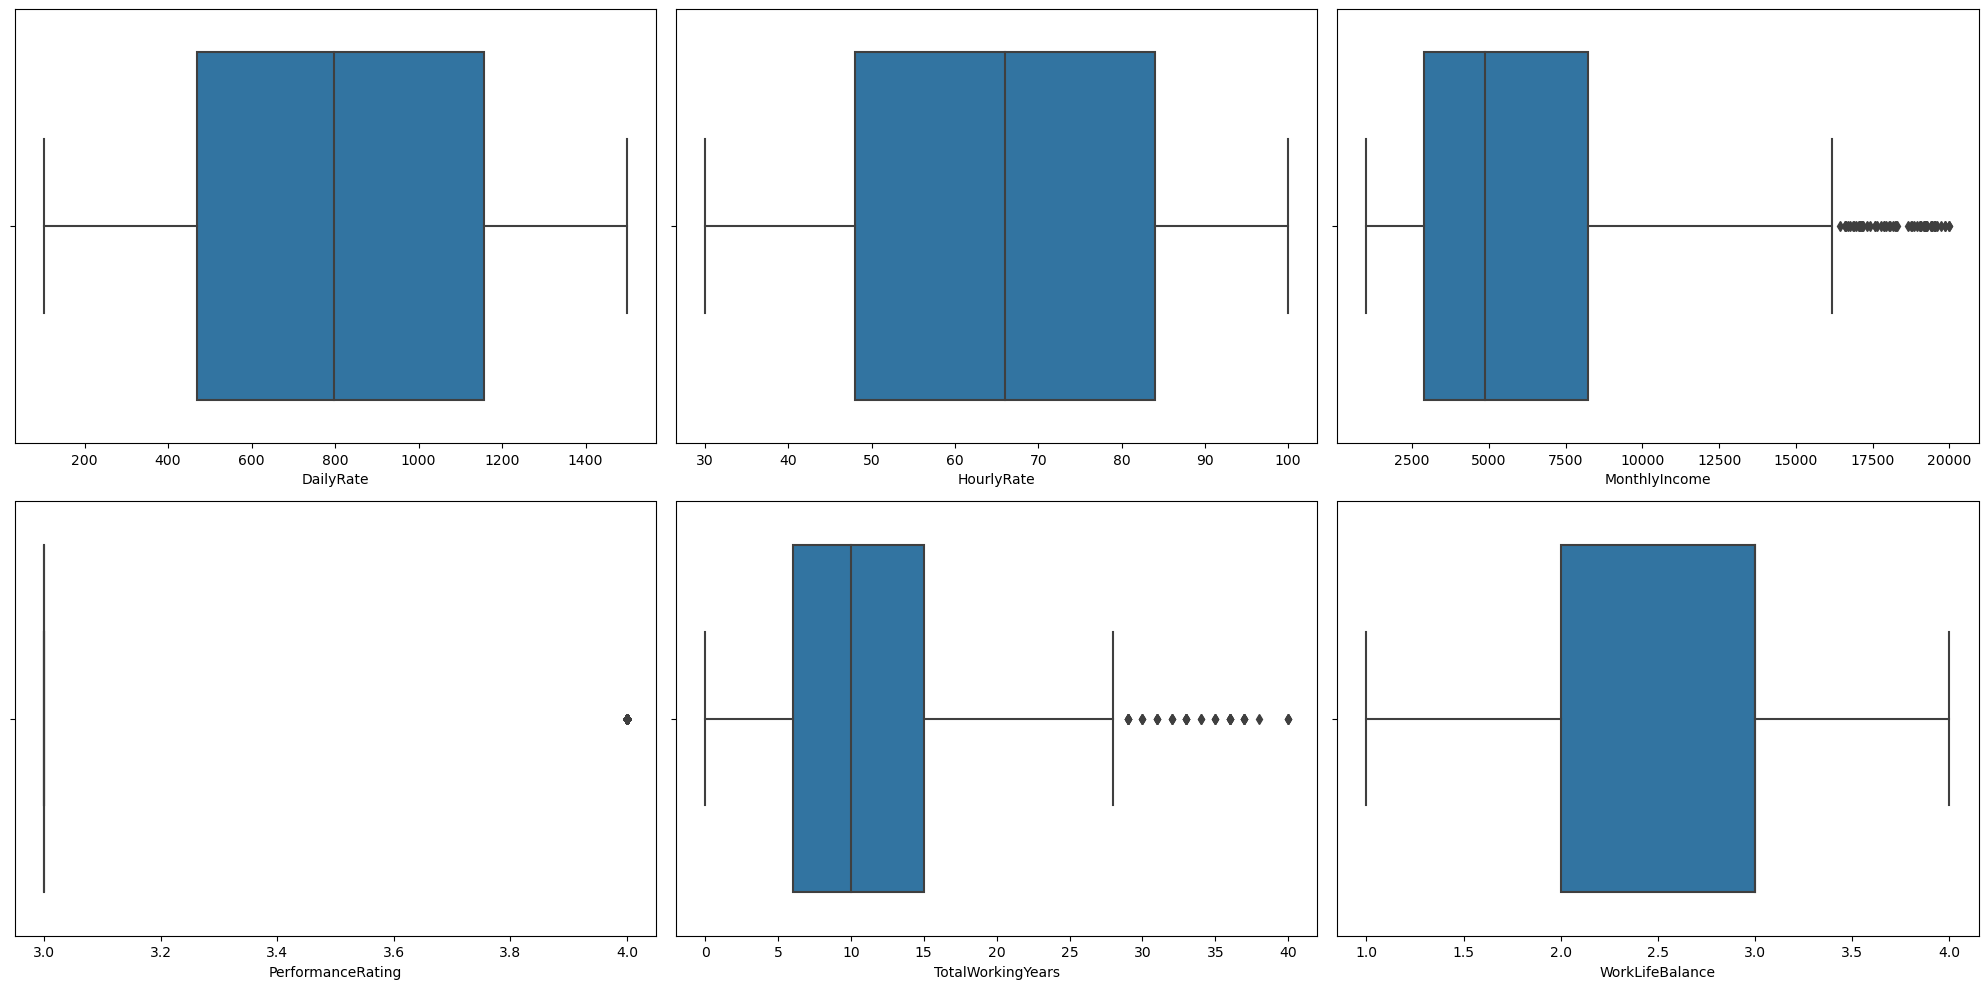

In [202]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,10)) 

axes = axes.flat

for indice, col in enumerate(nulos_num):
    sns.boxplot(x = col, data = df_imputada, ax = axes[indice])
    
plt.tight_layout()

#### 1.1 `fillna()`

- `DailyRate`, `HourlyRate`, `WorkLifeBalance` son columnas numéricas que no superan el 5-10% de valores nulos y no tienen valores atípicos o outliers. Para imputarlas optaremos por reemplazar por la media o mediana usando el método `.fillna()` (también se podría usar `SimpleImputer` de Sklearn, pero de momento no es necesario usar ningún otro método más avanzado).


In [203]:
# Guardamos en una lista las columnas que gestionaremos usando el método 'fillna()'
col_fillna = ['DailyRate', 'HourlyRate', 'WorkLifeBalance']

# Para decidir si usamos la media o la mediana lo que haremos es hacer un describe de cada columna para saber cuales son estos valores
stats = df_imputada[col_fillna].describe().transpose()[["mean", "50%"]]
print(stats)

                       mean    50%
DailyRate        802.085235  798.0
HourlyRate        66.028105   66.0
WorkLifeBalance    2.759628    3.0


En el caso de `DailyRate` y `HourlyRate`, la media y la mediana son la misma así que daría igual cuál usar. En el caso de `WorkLifeBalance`, esta difiere un poco. Usaremos la mediana ya que es un número sin decimales.

In [204]:
print(f"Los valores únicos de la columa 'WorkLifeBalance' son numeros sin decimales: {df_imputada['WorkLifeBalance'].unique()}")

Los valores únicos de la columa 'WorkLifeBalance' son numeros sin decimales: [ 3. nan  2.  4.  1.]


In [205]:
# Recorremos las columnas
for col in col_fillna:
    # Calculamos la mediana para cada columna
    mediana = df_imputada[col].median()
    print(f"La media de la columna {col} es: {round(mediana, 2)}")

    # Aplicamos el método 'fillna()' a la columna
    df_imputada[col] =  df_imputada[col].fillna(mediana)

# Comprobamos los nulos de las columnas
print(f"\nDespués del 'fillna' tenemos: \n{df_imputada[col_fillna].isnull().sum()} nulos")

La media de la columna DailyRate es: 798.0
La media de la columna HourlyRate es: 66.0
La media de la columna WorkLifeBalance es: 3.0

Después del 'fillna' tenemos: 
DailyRate          0
HourlyRate         0
WorkLifeBalance    0
dtype: int64 nulos


#### 1.2 KKNImputer o IterativeImputer

- `MonthlyIncome`, `PerformanceRating`, `TotalWorkingYears`: estas columnas tienen valores atípicos por lo que optaremos por reemplazar los nulos con métodos más avanzados como KNNImputer y IterativeImputer. Aplicaremos los dos métodos a las columnas y veremos si hay diferencias o no.

In [208]:
# Guardamos en una lista las columnas con outliers que gestionaremos usando métodos avanzados
col_outliers = ['MonthlyIncome', 'PerformanceRating', 'TotalWorkingYears']

In [210]:
print(f"El porcentaje de nulos de cada columna con outliers es: \n{df_imputada[col_outliers].isnull().sum() / df_imputada.shape[0]}\n")

El porcentaje de nulos de cada columna con outliers es: 
MonthlyIncome        0.522305
PerformanceRating    0.120818
TotalWorkingYears    0.325898
dtype: float64



### 2. Imputación categórica

In [211]:
# Obtenemos la lista de columnas categoricas que tienen nulos
nulos_cat = df_imputada[df_imputada.columns[df_imputada.isnull().any()]].select_dtypes(include = "O").columns
print("Las columnas categóricas que tienen nulos son : \n ")
print(nulos_cat)

# Calculamos el numero de nulos en cada una de las columnas categoricas
df_imputada[nulos_cat].isnull().sum() / df_imputada.shape[0]

Las columnas categóricas que tienen nulos son : 
 
Index(['BusinessTravel', 'Department', 'EducationField', 'EmployeeNumber',
       'MaritalStatus', 'OverTime'],
      dtype='object')


BusinessTravel    0.478315
Department        0.812887
EducationField    0.461586
EmployeeNumber    0.267038
MaritalStatus     0.403346
OverTime          0.418835
dtype: float64

In [212]:
# Sacamos el 'value_counts()' de cada una de las columnas categóricas que tienen nulos para saber como es la distribución de sus categorías
for col in nulos_cat:
    print(f"La distribución de las categorías para la columna {col.upper()}")
    display(df_imputada[col].value_counts() / df_imputada.shape[0])
    print("........................")

La distribución de las categorías para la columna BUSINESSTRAVEL


BusinessTravel
travel_rarely        0.363073
travel_frequently    0.102230
non_travel           0.056382
Name: count, dtype: float64

........................
La distribución de las categorías para la columna DEPARTMENT


Department
research_and_development    0.121437
sales                       0.056382
human_resources             0.009294
Name: count, dtype: float64

........................
La distribución de las categorías para la columna EDUCATIONFIELD


EducationField
life_sciences       0.216233
medical             0.171004
marketing           0.064436
technical_degree    0.042751
other               0.036555
human_resources     0.007435
Name: count, dtype: float64

........................
La distribución de las categorías para la columna EMPLOYEENUMBER


EmployeeNumber
482,0     0.001239
530,0     0.001239
507,0     0.001239
517,0     0.001239
522,0     0.001239
523,0     0.001239
525,0     0.001239
526,0     0.001239
544,0     0.001239
501,0     0.001239
725,0     0.001239
724,0     0.001239
722,0     0.001239
721,0     0.001239
717,0     0.001239
710,0     0.001239
502,0     0.001239
495,0     0.001239
747,0     0.001239
440,0     0.001239
734,0     0.001239
733,0     0.001239
728,0     0.001239
423,0     0.001239
424,0     0.001239
433,0     0.001239
447,0     0.001239
1140,0    0.001239
455,0     0.001239
460,0     0.001239
465,0     0.001239
470,0     0.001239
475,0     0.001239
478,0     0.001239
682,0     0.001239
663,0     0.001239
653,0     0.001239
1069,0    0.001239
389,0     0.001239
388,0     0.001239
381,0     0.001239
376,0     0.001239
1044,0    0.001239
1053,0    0.001239
1195,0    0.001239
621,0     0.001239
1185,0    0.001239
1162,0    0.001239
1161,0    0.001239
1160,0    0.001239
1157,0    0.001239
1131,0    0.0012

........................
La distribución de las categorías para la columna MARITALSTATUS


MaritalStatus
married     0.271995
single      0.201363
divorced    0.123296
Name: count, dtype: float64

........................
La distribución de las categorías para la columna OVERTIME


OverTime
no     0.422553
yes    0.158612
Name: count, dtype: float64

........................


#### 2.1 Reemplazar por nueva categoría `unknown`

#### 2.2 Reemplazar por categoría dominante o moda

### 3. Eliminar columnas con demasiados nulos

Eliminamos columnas con demasiados nulos:

- Si el 80% de los registros son nulos eliminamos los atributos:

In [ ]:
# Calcula el porcentaje de valores nulos para cada atributo
porcentaje_nulos = df_imputada.isna().mean() * 100

# Filtra los atributos donde el porcentaje de nulos sea mayor al 80%
columnas_80_nulos = porcentaje_nulos[porcentaje_nulos > 80]

# Obtiene los nombres de los atributos 
columnas_a_eliminar = columnas_80_nulos.index.tolist()
print("Atributos con más del 80/%/ de valores nulos:")
print(columnas_a_eliminar)

In [ ]:
# Eliminamos las columnas seleccionadas
# df_imputada.drop(columns=columnas_a_eliminar, axis = 1, inplace=True)
# print(f"Las columnas {columnas_a_eliminar} han sido eliminadas")

## ÚLTIMO PASO

Guardamos el DataFrame con datos transformados en un nuevo archivo CSV.

In [ ]:
# Guardamos el DataFrame limpio en un nuevo archivo CSV
output_file_path = 'hr_data_imputado.csv'
#df_imputada.to_csv(output_file_path, index=False)
print(f"El DataFrame modificado ha sido guardado en '{output_file_path}'.")